In [2]:
import numpy as np 
import os
from glob import glob
from astropy.io import fits
from tqdm import tqdm
import matplotlib.pyplot as plt
import statistics
from scipy.optimize import curve_fit
from scipy.interpolate import splrep, splev
from scipy.interpolate import UnivariateSpline
from numpy.polynomial import Legendre, Chebyshev


In [3]:
with open('user_input.txt', 'r') as file:
    lines = file.readlines()

path = lines[0].strip()
mflat = os.path.join(path, 'mflat.fits')
data = fits.open(mflat)[0].data
header = fits.open(mflat)[0].header
xpixels = header['NAXIS1']
ypixels = header['NAXIS2']


normalised_data = np.mean(data, axis=1)

In [4]:
pixels = np.arange(0,ypixels,1)

<Figure size 504x504 with 0 Axes>

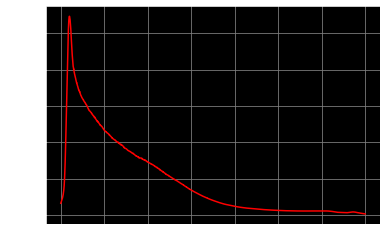

In [5]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
# Plot some data

# Set borders (spines)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Erase the grid
ax.grid(True, color='grey')

plt.plot(pixels, normalised_data, c ='red')


In [26]:
parameters = {
        "naverage": 1,
        "function": "spline",
        "order": 1,
        "lreject": 3.0,
        "hreject": 3.0,
        "iter": 5
    }

naverage = parameters['naverage']
function = parameters['function']
order = parameters['order']
lreject = parameters['lreject']
hreject = parameters['hreject']
iter = parameters['iter']


Text(0.5, 1.0, 'naverage: 1, function: spline, order: 1, lreject: 3.0, hreject: 3.0, iter: 5, rms: 1.000010124825319')

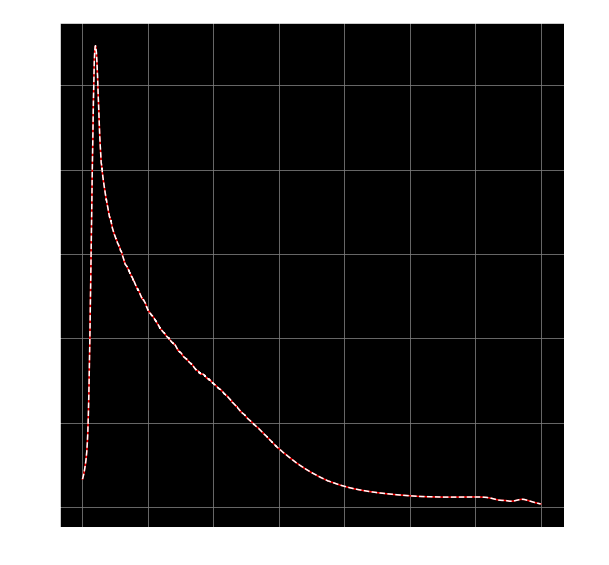

In [30]:
normalised_data = np.mean(data, axis=1)
normalised_data = np.mean(data, axis=1)
pixels = np.arange(0,ypixels,1)
sample_points = []
for i in range(0,len(normalised_data),abs(int(naverage))):
    while True:
        if naverage > 0:
            sample_points.append(np.mean(normalised_data[i:i+int(naverage)]))
            break
        elif naverage < 0 :
            sample_points.append(statistics.median(normalised_data[i:i+abs(int(naverage))]))
            break
        else :
            print("Enter either a positive or negative number")
            naverage = input("naverage: ")
            continue
sample_pixels = np.arange(0,ypixels,abs(int(naverage)))

#tck = splrep(sample_pixels, sample_points, k=order)
#y_fit = splev(sample_pixels, tck)
spline = UnivariateSpline(sample_pixels, sample_points, k=order)
y_fit = spline(sample_pixels)
residuals = sample_points - y_fit
rms_error = np.sqrt(np.mean(residuals**2))        
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0,0,1,1])
ax.plot(pixels, normalised_data, c ='red')
ax.plot(sample_pixels,y_fit, ls='--', c="white")
ax.grid(True, color='grey')
ax.set_xlabel("dispersion pixels")
ax.set_ylabel("Counts")
ax.set_title("naverage: {}, function: {}, order: {}, lreject: {}, hreject: {}, iter: {}, rms: {}".format(naverage, function, order, lreject, hreject, iter, rms_error))     

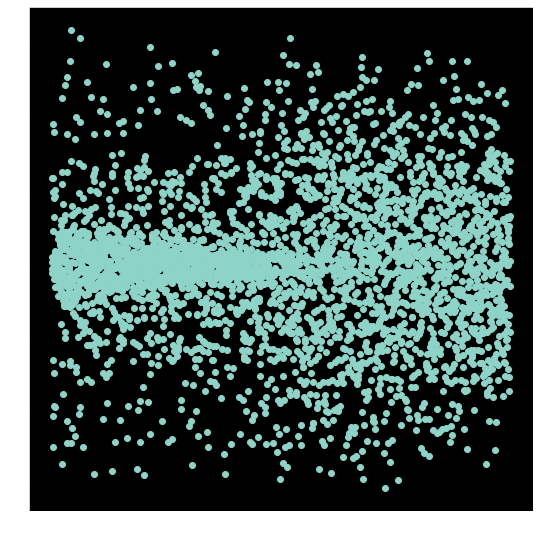

In [31]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0,0,1,1])
ax.scatter(sample_pixels, residuals)

In [32]:
std_residuals = np.std(residuals)
std_residuals

1.0000101248253188

In [43]:
len(np.interp(pixels, sample_pixels, y_fit))

3500

NameError: name 'pixels' is not defined

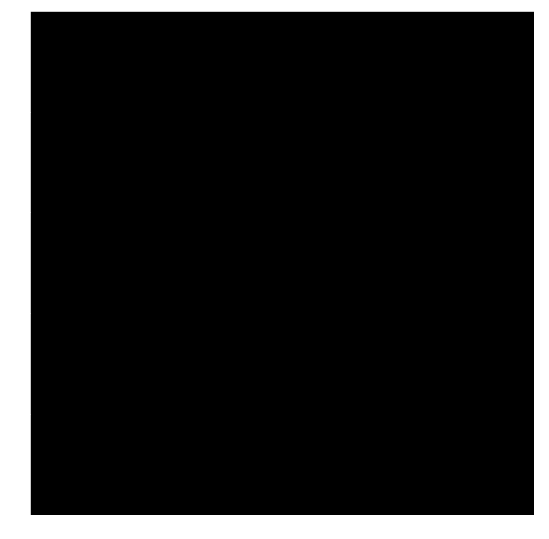

In [1]:
from astropy.io import fits
import os 
import numpy as np
import statistics
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from numpy.polynomial import Legendre, Chebyshev
import matplotlib.pyplot as plt
plt.style.use('dark_background')

with open('user_input.txt', 'r') as file:
    lines = file.readlines()

path = lines[0].strip()
mflat = os.path.join(path, 'mflat.fits')

header = fits.open(mflat)[0].header
xpixels = header['NAXIS1']
ypixels = header['NAXIS2']

def fit(iter, function, sample_pixels, sample_points, order, lreject, hreject):
    for j in  range(0,iter):
        if function == "spline":
            spline = UnivariateSpline(sample_pixels, sample_points, k=order)
            y_fit = spline(sample_pixels)
        elif function == "legendre":
            coefficients = np.polynomial.legendre.Legendre.fit(sample_pixels, sample_points, deg=order).convert().coef
            y_fit = np.polynomial.legendre.legval(sample_points, coefficients)
        else:
            coefficients = np.polynomial.chebyshev.Chebyshev.fit(sample_points, sample_pixels, deg=order).convert().coef
            y_fit = np.polynomial.chebyshev.chebval(sample_points, coefficients)
        residuals = sample_points - y_fit
        rms_error = np.sqrt(np.mean(residuals**2))
        std_residuals = np.std(residuals)
        rejected_indices = np.where(np.logical_or(residuals > hreject * std_residuals, residuals < lreject * std_residuals))[0]
        sample_pixels = np.delete(sample_pixels, rejected_indices)
        sample_points = np.delete(sample_points, rejected_indices)
    return sample_pixels, sample_points, y_fit, rms_error

def plot_fit():# y_fit, rms_error, naverage, function, order, lreject, hreject, iter):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(pixels, normalised_data, c ='red')
    ax.plot(sample_pixels,y_fit, ls='--', c="white")
    ax.grid(True, color='grey')
    ax.set_xlabel("Dispersion axis pixels")
    ax.set_ylabel("Counts")
    ax.set_title("naverage: {}, function: {}, order: {}, lreject:{}, hreject: {}, iter: {}, rms = {}".format(naverage, function, order, lreject, hreject, iter, rms_error))
    plt.show()

def para_check(parameters):
    print("Do you want to change the parameters (default values are shown):")
    while True:
        for param, default in parameters.items():
            print(f"{param} (default: {default})")
        param = input("Enter the parameter you want to input (or 'done' to finish): ")
        if param.lower() == 'done':
            break
        if param in parameters:
            value = input(f"{param} (default: {parameters[param]}): ")
            if ' ' in value:
                print("Invalid input. This parameter should not contain a space.")
                continue
            if param == 'function':
                # Check if the input is one of the four options
                if value in function_options:
                    parameters[param] = value
                else:
                    print("Invalid input. 'function' parameter should be one of the following: " + ", ".join(function_options))
            else:
                # Check if the input can be converted to a number
                try:
                    value = float(value)
                    parameters[param] = value
                except ValueError:
                    print("Invalid input. This parameter should be a number.")
        else:
            print("Invalid parameter. Please try again.")
    naverage = parameters['naverage']
    function = parameters['function']
    order = parameters['order']
    lreject = parameters['lreject']
    hreject = parameters['hreject']
    iter = parameters['iter']
    return naverage, function, order, lreject, hreject, iter

#parameters= naverage, function, order, lreject, hreject, iter
def response(data, naverage, function,order, lreject, hreject, iter):
    normalised_data = np.mean(data, axis=1)
    pixels = np.arange(0,ypixels,1)
    sample_points = []
    for i in range(0,len(normalised_data),abs(int(naverage))):
        while True:
            if naverage > 0:
                sample_points.append(np.mean(normalised_data[i:i+int(naverage)]))
                break
            elif naverage < 0 :
                sample_points.append(statistics.median(normalised_data[i:i+abs(int(naverage))]))
                break
            else :
                print("Enter either a positive or negative number")
                naverage = input("naverage: ")
                continue
    sample_pixels = np.arange(0,ypixels,abs(int(naverage)))
    sample_pixels, sample_points, y_fit, rms_error = fit (iter, function, sample_pixels, sample_points, order, lreject, hreject)
    plot_fit()#pixels, normalised_data, sample_pixels, y_fit, rms_error, naverage, function, order, lreject, hreject, iter)
    while True:
        fit_check = input("Are you satisfied with the fit ? (y/n): ")
        if fit_check == 'y':
            break
        elif fit_check == 'n':
            naverage, function, order, lreject, hreject, iter = para_check(parameters)
            sample_pixels, sample_points, y_fit, rms_error = fit (iter, function, sample_pixels, sample_points, order, lreject, hreject)
            plot_fit()#pixels, normalised_data, sample_pixels, y_fit, rms_error, naverage, function, order, lreject, hreject, iter)
            continue
        else:
            print("wrong Choice")
            continue
    if abs(int(naverage)) != 1:
        y_fit = np.interp(pixels, sample_pixels, y_fit) 
    final_image = np.divide(data, y_fit[:, np.newaxis]) 
    return final_image

data = fits.open(mflat)[0].data
parameters = {
        "naverage": 1,
        "function": "spline",
        "order": 3,
        "lreject": 3.0,
        "hreject": 3.0,
        "iter": 1
    }
function_options = ["spline", "chebyshev", "legendre"]
naverage = parameters['naverage']
function = parameters['function']
order = parameters['order']
lreject = parameters['lreject']
hreject = parameters['hreject']
iter = parameters['iter']


output_filename = os.path.join(path,'nmflat.fits')
response(data, naverage, function,order, lreject, hreject, iter)

Do you want to change the parameters (default values are shown):
naverage (default: 0)
function (default: spline)
order (default: 3)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 1)
naverage cannot be zero. Enter either a positive or negative number


ValueError: x and y must have same first dimension, but have shapes (0,) and (3500,)

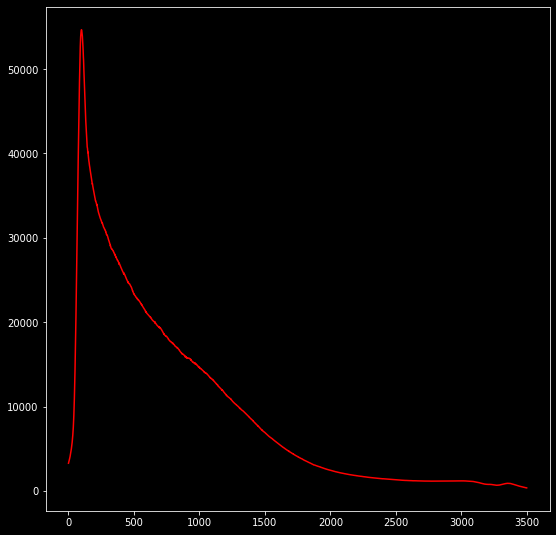

In [8]:
from astropy.io import fits
import os 
import numpy as np
import statistics
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from numpy.polynomial import Legendre, Chebyshev
import matplotlib.pyplot as plt
plt.style.use('dark_background')

with open('user_input.txt', 'r') as file:
    lines = file.readlines()

path = lines[0].strip()
mflat = os.path.join(path, 'mflat.fits')

header = fits.open(mflat)[0].header
xpixels = header['NAXIS1']
ypixels = header['NAXIS2']

#parameters= naverage, function, order, lreject, hreject, iter
def response(data, ypixels):
    parameters = {
        "naverage": 0,
        "function": "spline",
        "order": 3,
        "lreject": 3.0,
        "hreject": 3.0,
        "iter": 1
    }
    function_options = ["spline", "chebyshev", "legendre"]

    #---------------------Entering the parameters--------------------
    print("Do you want to change the parameters (default values are shown):")
    while True:
        for param, default in parameters.items():
            print(f"{param} (default: {default})")
        param = input("Enter the parameter you want to input (or 'done' to finish): ")
        if param.lower() == 'done':
            break
        if param in parameters:
            value = input(f"{param} (default: {parameters[param]}): ")
            if ' ' in value:
                print("Invalid input. This parameter should not contain a space.")
                continue
            if param == 'function':
                # Check if the input is one of the four options
                if value in function_options:
                    parameters[param] = value
                else:
                    print("Invalid input. 'function' parameter should be one of the following: " + ", ".join(function_options))
            else:
                # Check if the input can be converted to a number
                try:
                    value = float(value)
                    parameters[param] = value
                except ValueError:
                    print("Invalid input. This parameter should be a number.")
        else:
            print("Invalid parameter. Please try again.")
    naverage = parameters['naverage']
    function = parameters['function']
    order = parameters['order']
    lreject = parameters['lreject']
    hreject = parameters['hreject']
    iter = parameters['iter']
    #---------------------------Fitting the data------------------------
    sample_points = []
    while True:
        if abs(int(naverage)) == 0:
            print("naverage cannot be zero. Enter either a positive or negative number")
            naverage = int(input("naverage: "))
            continue
        else:
            break
    sample_pixels = np.arange(0,ypixels,abs(int(naverage)))
    for i in range(0,len(normalised_data),abs(int(naverage))):
        if naverage > 0:
            sample_points.append(np.mean(normalised_data[i:i+int(naverage)]))
        else:
            sample_points.append(statistics.median(normalised_data[i:i+abs(int(naverage))]))
    for j in  range(0,iter):
        if function == "spline":
            spline = UnivariateSpline(sample_pixels, sample_points, k=order)
            y_fit = spline(sample_pixels)
        elif function == "legendre":
            coefficients = np.polynomial.legendre.Legendre.fit(sample_pixels, sample_points, deg=order).convert().coef
            y_fit = np.polynomial.legendre.legval(sample_points, coefficients)
        else:
            coefficients = np.polynomial.chebyshev.Chebyshev.fit(sample_points, sample_pixels, deg=order).convert().coef
            y_fit = np.polynomial.chebyshev.chebval(sample_points, coefficients)
        residuals = sample_points - y_fit
        rms_error = np.sqrt(np.mean(residuals**2))
        std_residuals = np.std(residuals)
        rejected_indices = np.where(np.logical_or(residuals > hreject * std_residuals, residuals < lreject * std_residuals))[0]
        sample_pixels = np.delete(sample_pixels, rejected_indices)
        sample_points = np.delete(sample_points, rejected_indices)
    
    #--------------------------------Plotting the fit--------------------------------------
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(pixels, normalised_data, c ='red')
    ax.plot(sample_pixels,y_fit, ls='--', c="white")
    ax.grid(True, color='grey')
    ax.set_xlabel("Dispersion axis pixels")
    ax.set_ylabel("Counts")
    ax.set_title("naverage: {}, function: {}, order: {}, lreject:{}, hreject: {}, iter: {}, rms = {}".format(naverage, function, order, lreject, hreject, iter, rms_error))
    plt.show()

    #-----------------------------Checking the fit--------------------------------
    while True:
        fit_check = input("Are you satisfied with the fit ? (y/n): ")
        if fit_check == 'y':
            break
        elif fit_check == 'n':
            while True:
                for param, default in parameters.items():
                    print(f"{param} (default: {default})")
                param = input("Enter the parameter you want to input (or 'done' to finish): ")
                if param.lower() == 'done':
                    break
                if param in parameters:
                    value = input(f"{param} (default: {parameters[param]}): ")
                    if ' ' in value:
                        print("Invalid input. This parameter should not contain a space.")
                        continue
                    if param == 'function':
                        if value in function_options:
                            parameters[param] = value
                        else:
                            print("Invalid input. 'function' parameter should be one of the following: " + ", ".join(function_options))
                    else:
                        try:
                            value = float(value)
                            parameters[param] = value
                        except ValueError:
                            print("Invalid input. This parameter should be a number.")
                else:
                    print("Invalid parameter. Please try again.")
            naverage = parameters['naverage']
            function = parameters['function']
            order = parameters['order']
            lreject = parameters['lreject']
            hreject = parameters['hreject']
            iter = parameters['iter']
    
            sample_points = []
            while True:
                if abs(int(naverage)) == 0:
                    print("naverage cannot be zero. Enter either a positive or negative number")
                    naverage = int(input("naverage: "))
                    continue
                else:
                    break
            sample_pixels = np.arange(0,ypixels,abs(int(naverage)))
            for i in range(0,len(normalised_data),abs(int(naverage))):
                if naverage > 0:
                    sample_points.append(np.mean(normalised_data[i:i+int(naverage)]))
                else:
                    sample_points.append(statistics.median(normalised_data[i:i+abs(int(naverage))]))
            for j in  range(0,iter):
                if function == "spline":
                    spline = UnivariateSpline(sample_pixels, sample_points, k=order)
                    y_fit = spline(sample_pixels)
                elif function == "legendre":
                    coefficients = np.polynomial.legendre.Legendre.fit(sample_pixels, sample_points, deg=order).convert().coef
                    y_fit = np.polynomial.legendre.legval(sample_points, coefficients)
                else:
                    coefficients = np.polynomial.chebyshev.Chebyshev.fit(sample_points, sample_pixels, deg=order).convert().coef
                    y_fit = np.polynomial.chebyshev.chebval(sample_points, coefficients)
                residuals = sample_points - y_fit
                rms_error = np.sqrt(np.mean(residuals**2))
                std_residuals = np.std(residuals)
                rejected_indices = np.where(np.logical_or(residuals > hreject * std_residuals, residuals < lreject * std_residuals))[0]
                sample_pixels = np.delete(sample_pixels, rejected_indices)
                sample_points = np.delete(sample_points, rejected_indices)
    
            fig = plt.figure(figsize=(7,7))
            ax = fig.add_axes([0,0,1,1])
            ax.plot(pixels, normalised_data, c ='red')
            ax.plot(sample_pixels,y_fit, ls='--', c="white")
            ax.grid(True, color='grey')
            ax.set_xlabel("Dispersion axis pixels")
            ax.set_ylabel("Counts")
            ax.set_title("naverage: {}, function: {}, order: {}, lreject:{}, hreject: {}, iter: {}, rms = {}".format(naverage, function, order, lreject, hreject, iter, rms_error))
            plt.show()

            continue
        else:
            print("wrong Choice")
            continue
    if abs(int(naverage)) != 1:
        y_fit = np.interp(pixels, sample_pixels, y_fit) 
    final_image = np.divide(data, y_fit[:, np.newaxis]) 
    return final_image

data = fits.open(mflat)[0].data
normalised_data = np.mean(data, axis=1)
pixels = np.arange(0,ypixels,1)


output_filename = os.path.join(path,'nmflat.fits')

final = response(data, ypixels)

In [9]:
sample_pixels

NameError: name 'sample_pixels' is not defined

In [11]:
parameters = {
        "naverage": 0,
        "function": "spline",
        "order": 3,
        "lreject": 3.0,
        "hreject": 3.0,
        "iter": 1
    }
function_options = ["spline", "chebyshev", "legendre"]

#---------------------Entering the parameters--------------------
print("Do you want to change the parameters (default values are shown):")
while True:
    for param, default in parameters.items():
        print(f"{param} (default: {default})")
    param = input("Enter the parameter you want to input (or 'done' to finish): ")
    if param.lower() == 'done':
        break
    if param in parameters:
        value = input(f"{param} (default: {parameters[param]}): ")
        if ' ' in value:
            print("Invalid input. This parameter should not contain a space.")
            continue
        if param == 'function':
            # Check if the input is one of the four options
            if value in function_options:
                parameters[param] = value
            else:
                print("Invalid input. 'function' parameter should be one of the following: " + ", ".join(function_options))
        else:
            # Check if the input can be converted to a number
            try:
                value = float(value)
                parameters[param] = value
            except ValueError:
                print("Invalid input. This parameter should be a number.")
    else:
        print("Invalid parameter. Please try again.")
naverage = parameters['naverage']
function = parameters['function']
order = parameters['order']
lreject = parameters['lreject']
hreject = parameters['hreject']
iter = parameters['iter']


Do you want to change the parameters (default values are shown):
naverage (default: 0)
function (default: spline)
order (default: 3)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 1)


In [35]:
sample_points = []
while True:
    if abs(int(naverage)) == 0:
        print("naverage cannot be zero. Enter either a positive or negative number")
        naverage = int(input("naverage: "))
        continue
    else:
        break
    
sample_pixels = np.arange(0,ypixels,abs(int(naverage)))
for i in range(0,len(normalised_data),abs(int(naverage))):
    if naverage > 0:
        sample_points.append(np.mean(normalised_data[i:i+int(naverage)]))
    else:
        sample_points.append(statistics.median(normalised_data[i:i+abs(int(naverage))]))
for j in  range(0,iter):
    if function == "spline":
        spline = UnivariateSpline(sample_pixels, sample_points, k=order)
        y_fit = spline(sample_pixels)
    elif function == "legendre":
        coefficients = np.polynomial.legendre.Legendre.fit(sample_pixels, sample_points, deg=order).convert().coef
        y_fit = np.polynomial.legendre.legval(sample_points, coefficients)
    else:
        coefficients = np.polynomial.chebyshev.Chebyshev.fit(sample_points, sample_pixels, deg=order).convert().coef
        y_fit = np.polynomial.chebyshev.chebval(sample_points, coefficients)
    residuals = sample_points - y_fit
    rms_error = np.sqrt(np.mean(residuals**2))
    std_residuals = np.std(residuals)
    rejected_indices = np.where(np.logical_or(residuals > (np.mean(residuals) + (hreject * std_residuals)), residuals < (np.mean(residuals) - (lreject * std_residuals))))[0]
    sample_pixels = np.delete(sample_pixels, rejected_indices)
    sample_points = np.delete(sample_points, rejected_indices)


In [16]:
sample_pixels = np.arange(0,ypixels,abs(int(naverage)))

In [33]:
rejected_indices1 = np.where(residuals > (np.mean(residuals) + (hreject * std_residuals)))[0]
rejected_indices2 = np.where(residuals < (np.mean(residuals) - (lreject * std_residuals)))[0]
rejected_indices = np.concatenate((rejected_indices1, rejected_indices2))

In [38]:
len(sample_pixels)

3496

In [32]:
np.mean(residuals)

-6.487864214120366e-12